In [1]:
import logging

logging.basicConfig(level=logging.INFO)

In [2]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss, MSELoss

# from pennylane import NesterovMomentumOptimizer

from qcc.ml.data import Data, BinaryData
from qcc.ml.optimize import Optimizer
from qcc.ml.data import ImageTransform, ImageTransform1D
from qcc.experiment import Experiment
from qcc.ml.model import Model

from pathlib import Path
from qcc.file import new_dir

from qcc.quantum.pennylane.ansatz import MQCCOptimized as Module
# from qcc.quantum.qiskit.qcnn import QCNN as Module

# from qcc.quantum.pennylane.ansatz.basic import BasicFiltering6
from qcc.quantum.pennylane.fully_connected import FullyConnected
from qcc.quantum.pennylane.c2q import ConvolutionAngleFilter, ConvolutionComplexAngleFilter, ConvolutionFilter
from qcc.quantum.pennylane.convolution import define_filter

INFO:qcc.ml.ml:Using CUDA on device cuda


In [3]:
# Meta parameters
name = "unitary_oldfc"
filename = Path(f"results/{name}")
num_trials = 10
silent = False
is_quantum = True

# Ansatz parameters
dims = (16, 16)
num_layers = 3
module_options = {
    "U_filter": ConvolutionFilter,
    "pre_op": True,
    # "num_features": 4,
    # "U_fully_connected": define_filter(num_layers=2),
    # "pooling": True,
    # "filter_shape": (2, 2, 2),
}

INFO:qcc.quantum.pennylane.ansatz.ansatz:Depth: 14
INFO:qcc.quantum.pennylane.ansatz.ansatz:Gate Count: 68
2023-10-07 02:44:44,603: (mqccoptimized) Circuit ID: unitary_oldfc
2023-10-07 02:44:44,604: (mqccoptimized) module=MQCCOptimized()
2023-10-07 02:44:44,604: (mqccoptimized) data=BinaryData(dataset=<class 'torchvision.datasets.mnist.FashionMNIST'>, transform=image_transform, target_transform=None, batch_size=(8, 1000), classes=[0, 1])
2023-10-07 02:44:44,605: (mqccoptimized) optimizer=<class 'torch.optim.adam.Adam'>, self.args=(), self.kwargs={}
2023-10-07 02:44:44,605: (mqccoptimized) loss=CrossEntropyLoss()
2023-10-07 02:44:44,605: (mqccoptimized) num_trials=10
2023-10-07 02:44:44,606: (mqccoptimized) dims=(16, 16)
2023-10-07 02:44:44,606: (mqccoptimized) num_layers=3
2023-10-07 02:44:44,606: (mqccoptimized) module_options={'U_filter': <class 'qcc.quantum.pennylane.c2q.ConvolutionFilter'>, 'pre_op': True}


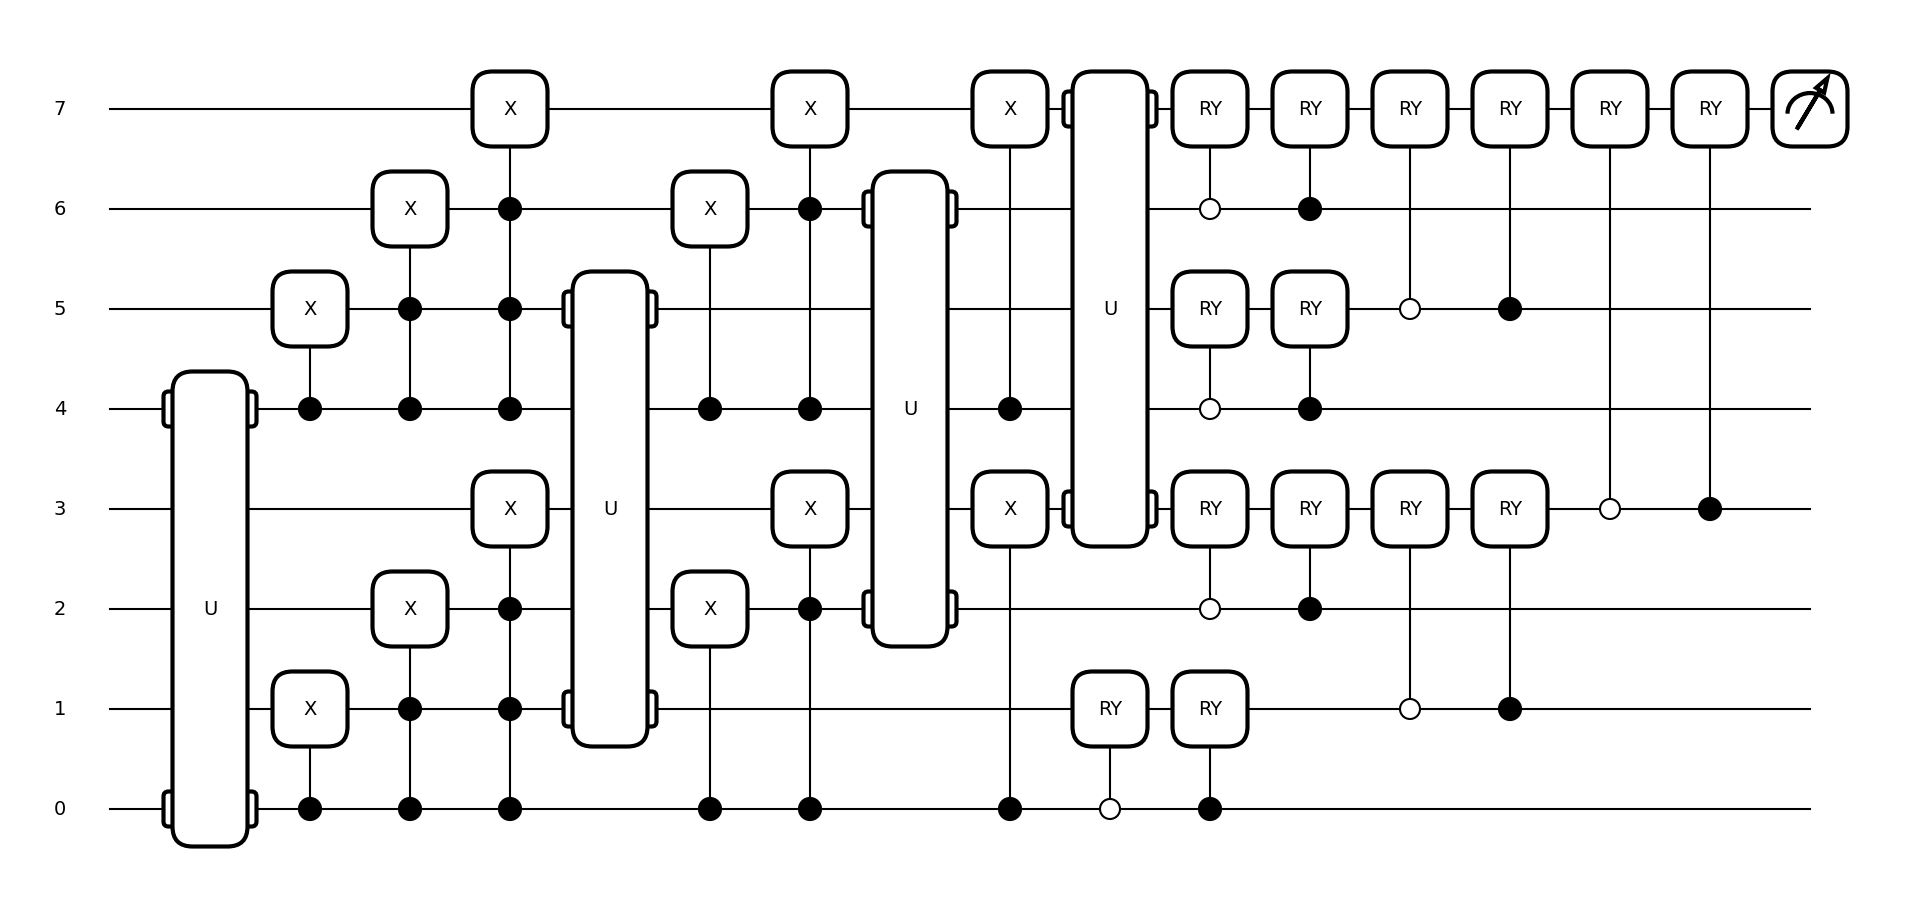

In [4]:
filename = new_dir(filename, overwrite=True)
filename = filename / name

if is_quantum:
    module = Module.from_dims
else:
    module = Module

# Create module
module = module(
    dims,
    num_layers=num_layers,
    **module_options,
)
data = BinaryData(
    FashionMNIST,
    ImageTransform(dims),
    batch_size=(8,1000),
)
optimizer = Optimizer(Adam)
loss = CrossEntropyLoss()
model = Model.with_logging(module, data, optimizer, loss, epoch=8)

# Log important values
model.logger.info(f"Circuit ID: {name}")
model.logger.info(f"{module=}")
model.logger.info(f"{data=}")
model.logger.info(f"{optimizer=}")
model.logger.info(f"{loss=}")

model.logger.info(f"{num_trials=}")
model.logger.info(f"{dims=}")
model.logger.info(f"{num_layers=}")
# model.logger.info(f"{1=}")
model.logger.info(f"{module_options=}")

# Save circuit drawing
if is_quantum:
    filename = filename.with_stem(f"{name}_circuit")
    module.draw(filename=filename, decompose=True)

In [5]:
# Run experiment
results_schema = ["accuracy", "training_time", "testing_time"]
experiment = Experiment(model, num_trials, results_schema)
# experiment.partial(silent=silent)
results = experiment(filename=filename)

2023-10-07 02:44:44,968: (mqccoptimized_trial_0) Number of Parameters: 30
2023-10-07 02:45:46,133: (mqccoptimized_trial_0) (Epoch 1) Training took 48.17280 sec
2023-10-07 02:45:46,665: (mqccoptimized_trial_0) (Epoch 1) Testing took: 0.53003 sec
2023-10-07 02:45:46,665: (mqccoptimized_trial_0) (Epoch 1) Accuracy: 81.500%
2023-10-07 02:46:48,261: (mqccoptimized_trial_0) (Epoch 2) Training took 95.08804 sec
2023-10-07 02:46:48,797: (mqccoptimized_trial_0) (Epoch 2) Testing took: 0.53423 sec
2023-10-07 02:46:48,798: (mqccoptimized_trial_0) (Epoch 2) Accuracy: 88.800%
2023-10-07 02:47:51,731: (mqccoptimized_trial_0) (Epoch 3) Training took 141.19617 sec
2023-10-07 02:47:52,256: (mqccoptimized_trial_0) (Epoch 3) Testing took: 0.52283 sec
2023-10-07 02:47:52,256: (mqccoptimized_trial_0) (Epoch 3) Accuracy: 91.050%
2023-10-07 02:48:53,817: (mqccoptimized_trial_0) (Epoch 4) Training took 188.13615 sec
2023-10-07 02:48:54,353: (mqccoptimized_trial_0) (Epoch 4) Testing took: 0.53221 sec
2023-10-0

In [ ]:
# Print accuracy results
metrics = ("median", "mean", "max", "min", "std")
for name in results.columns:
    col = results[name]
    msg = (f"{metric}={getattr(col, metric)()}" for metric in metrics)
    msg = ", ".join(msg)
    msg = f"{name}: {msg}"
    model.logger.info(msg)

# Save aggregated loss history figure
display(experiment.draw(filename))